In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np


In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from ecotools.pi_client import pi_client

sns.set('paper')
# Option Paramater time_zone
# default timezone is time_zone='America/Los_Angeles' use https://www.iana.org/time-zones 

#pi = pi_client(username= r'ad3\username')
pi = pi_client(username = r'ad3\sbharadw')

Connecting to PI API using 'basic authentication'


In [3]:
tags = ['CCAH_ChilledWater_Demand_kBtu', 'aiTIT4045']

In [4]:
start = '2022-07-05'
end = '*'
interval = '1h' # Can be "min" "h" "d"
calculation = 'summary'
summary_calc = 'average'
weight = 'TimeWeighted'

df = pi.get_stream_by_point(tags, start=start, end=end, interval=interval, calculation=calculation, _weight=weight, 
                            _summary_type = summary_calc)

df.head()

00:32:50: Sending API request... Chunk 1 of 1
00:32:54: Response recieved for 2 tags! (3.39)


,CCAH_ChilledWater_Demand_kBtu,aiTIT4045
Timestamp,,
2022-07-05 00:00:00,1110.775996,72.262881
2022-07-05 01:00:00,1106.332959,72.216921
2022-07-05 02:00:00,1041.997232,70.612774
2022-07-05 03:00:00,1070.060387,69.756020
2022-07-05 04:00:00,1058.919854,69.406466


# First Model (Demand vs OAT):

In [5]:
# Assuming 'df' contains the data obtained from the PI System

# Preprocessing the data
# We'll drop any rows with missing values
df = df.dropna()

# Splitting the data into input (features) and output (labels)
inputs = df[['aiTIT4045']].values
outputs = df[['CCAH_ChilledWater_Demand_kBtu']].values

# Normalizing the data (scaling inputs to a range of 0 to 1)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
outputs = (outputs - outputs.min()) / (outputs.max() - outputs.min())


In [6]:
# Converting numpy arrays to PyTorch tensors
inputs = torch.FloatTensor(inputs)
outputs = torch.FloatTensor(outputs)

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(inputs))
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_outputs, test_outputs = outputs[:train_size], outputs[train_size:]

# Defining the neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
net = SimpleNN()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Training the model
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(train_inputs)
    loss = criterion(outputs, train_outputs)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training finished!")


Epoch 0, Loss: 0.057677
Epoch 10, Loss: 0.009320
Epoch 20, Loss: 0.005460
Epoch 30, Loss: 0.002684
Epoch 40, Loss: 0.002735
Epoch 50, Loss: 0.002534
Epoch 60, Loss: 0.002065
Epoch 70, Loss: 0.001911
Epoch 80, Loss: 0.001754
Epoch 90, Loss: 0.001651
Training finished!


In [7]:
# Testing the model
net.eval()
with torch.no_grad():
    test_outputs_pred = net(test_inputs)

# Converting predictions back to original scale (reverse normalization)
test_outputs_pred = (test_outputs_pred * (outputs.max() - outputs.min())) + outputs.min()

# Display the first few predictions and actual values
predictions_df = pd.DataFrame({'Predicted': test_outputs_pred.view(-1).detach().numpy(),
                               'Actual': test_outputs.view(-1).detach().numpy()})
print(predictions_df.head())

   Predicted    Actual
0   0.025362  0.049433
1   0.015022  0.051063
2  -0.028435  0.012434
3  -0.038659  0.005780
4  -0.040812  0.005232


<AxesSubplot:>

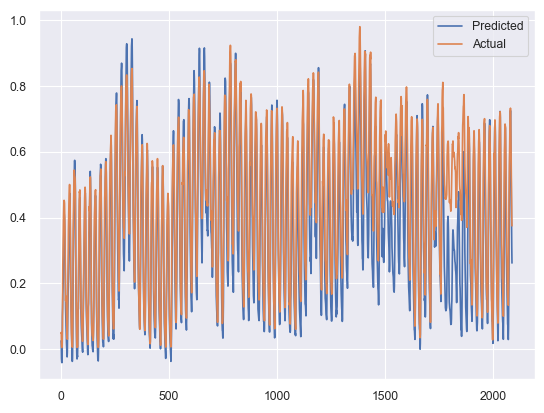

In [8]:
predictions_df.plot()

# Second Model (all inputs):

In [9]:
df.rename(columns = {'aiTIT4045':'OAT'}, inplace = True)
df.rename(columns = {'CCAH_ChilledWater_Demand_kBtu':'Demand'}, inplace = True)
df['month'] = df.index.month - 1
df['hour'] = df.index.hour 
df['day'] = df.index.dayofweek
df['CDH'] = 0 
df['HDH'] = 0
df.loc[df.OAT >= 65, 'CDH'] = df.loc[df.OAT >= 65, 'OAT']- 65
df.loc[df.OAT < 65, 'HDH'] = 65 - df.loc[df.OAT < 65, 'OAT']
df = pd.get_dummies(df, columns=['month','hour','day'])

In [10]:
df.columns

Index(['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')

In [11]:
input_data = df[['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6']].values

In [12]:
target_data = df['OAT'].values 

In [13]:
# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
target_tensor = torch.tensor(target_data, dtype=torch.float32).view(-1, 1)

In [14]:
# Split the data into training and testing sets (adjust the test_size as needed)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)


In [15]:
# Define a neural network model
class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Input size to 1 output
    
    def forward(self, x):
        return self.fc(x)


In [16]:
# Instantiate the model and loss function
model = SimpleModel(input_size=input_data.shape[1])
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate


In [17]:
model.load_state_dict(torch.load('trained_model.pth'))  # Load the trained model

<All keys matched successfully>

In [18]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(input_tensor)
    loss = criterion(predictions, target_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 1304.9796
Epoch [2/50], Loss: 1302.3835
Epoch [3/50], Loss: 1298.1740
Epoch [4/50], Loss: 1294.7081
Epoch [5/50], Loss: 1291.5590
Epoch [6/50], Loss: 1288.0819
Epoch [7/50], Loss: 1284.4182
Epoch [8/50], Loss: 1280.8597
Epoch [9/50], Loss: 1277.5034
Epoch [10/50], Loss: 1274.2166
Epoch [11/50], Loss: 1270.8342
Epoch [12/50], Loss: 1267.3435
Epoch [13/50], Loss: 1263.8387
Epoch [14/50], Loss: 1260.4067
Epoch [15/50], Loss: 1257.0580
Epoch [16/50], Loss: 1253.7296
Epoch [17/50], Loss: 1250.3574
Epoch [18/50], Loss: 1246.9390
Epoch [19/50], Loss: 1243.5216
Epoch [20/50], Loss: 1240.1488
Epoch [21/50], Loss: 1236.8215
Epoch [22/50], Loss: 1233.5039
Epoch [23/50], Loss: 1230.1628
Epoch [24/50], Loss: 1226.7991
Epoch [25/50], Loss: 1223.4403
Epoch [26/50], Loss: 1220.1102
Epoch [27/50], Loss: 1216.8076
Epoch [28/50], Loss: 1213.5110
Epoch [29/50], Loss: 1210.2031
Epoch [30/50], Loss: 1206.8873
Epoch [31/50], Loss: 1203.5813
Epoch [32/50], Loss: 1200.2965
Epoch [33/50], Lo

In [27]:
# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

In [21]:
# Set the model to evaluation mode
model.eval()

# Make predictions on the test data
with torch.no_grad():
    test_outputs_pred = model(X_test)
    

In [22]:
# Convert predictions and actual values to NumPy arrays
test_outputs_pred = test_outputs_pred.numpy()
y_test = y_test.numpy()

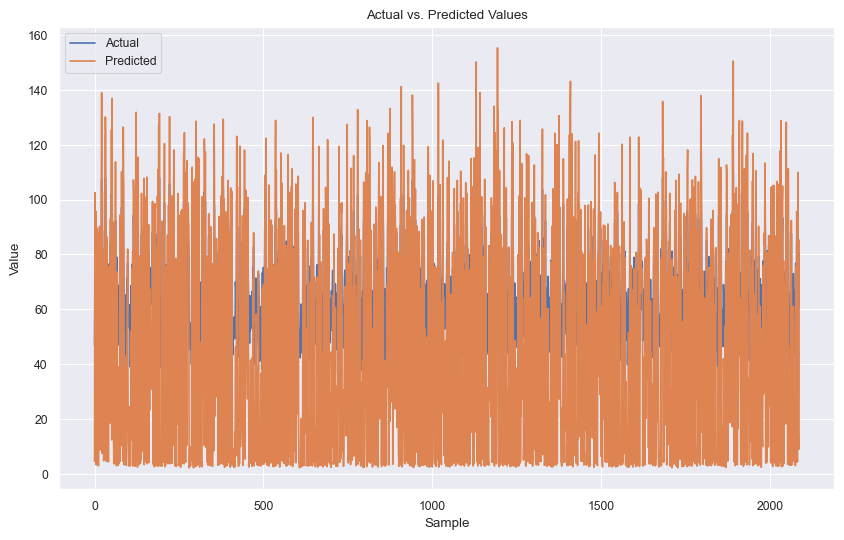

In [26]:
# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_outputs_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

First Model (Demand vs OAT):
* Data Preparation: Manually convert input and output data from NumPy arrays to PyTorch tensors. It also splits the data into training and testing sets using slicing. 
* Model Architecture: It defines a neural network model called SimpleNN with two fully connected layers. 
* Training Loop: The code includes a manual training loop where it computes gradients, updates model weights, and prints the loss for a specified number of epochs (100 in this case). 

Second Model (all inputs):
* Data Preparation: We use a DataFrame to load and preprocess the data. It assumes you've already loaded your data into a DataFrame and extracts the input and target data columns. 
* Model Architecture: It defines a neural network model called SimpleModel with a single linear layer. 
* Training Loop: The code includes a training loop where it computes gradients, updates model weights, and prints the loss for a specified number of epochs (50 in this case). 
* Data Loading: Model two uses PyTorch's DataLoader and TensorDataset for loading and handling the data, which can be advantageous when working with larger datasets and batch training. 

Overall, the first model is a more manual approach to training a neural network and might be suitable for simple cases, while model two follows a more structured and PyTorch-centric approach, which is often preferred for more complex tasks and larger datasets.
